# Capstone Project 2: Customer Segmentation

### 1. Import library

In [1]:
#importing libraries
import os,datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers,optimizers,losses,callbacks,applications,models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### 2. Load data

In [2]:
#load the data
CSV_PATH = os.path.join(os.getcwd(), 'customer_segmentation.csv')

In [3]:
df = pd.read_csv(CSV_PATH) 

### 3. Data inspection

In [4]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,8068.0,463479.214551,2595.381232,458982.0,461240.75,463472.5,465744.25,467974.0
Age,8068.0,43.466906,16.711696,18.0,30.00,40.0,53.00,89.0
Work_Experience,7239.0,2.641663,3.406763,0.0,0.00,1.0,4.00,14.0
Family_Size,7733.0,2.850123,1.531413,1.0,2.00,3.0,4.00,9.0


In [6]:
#check for missing values in the data
df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


### 4. EDA

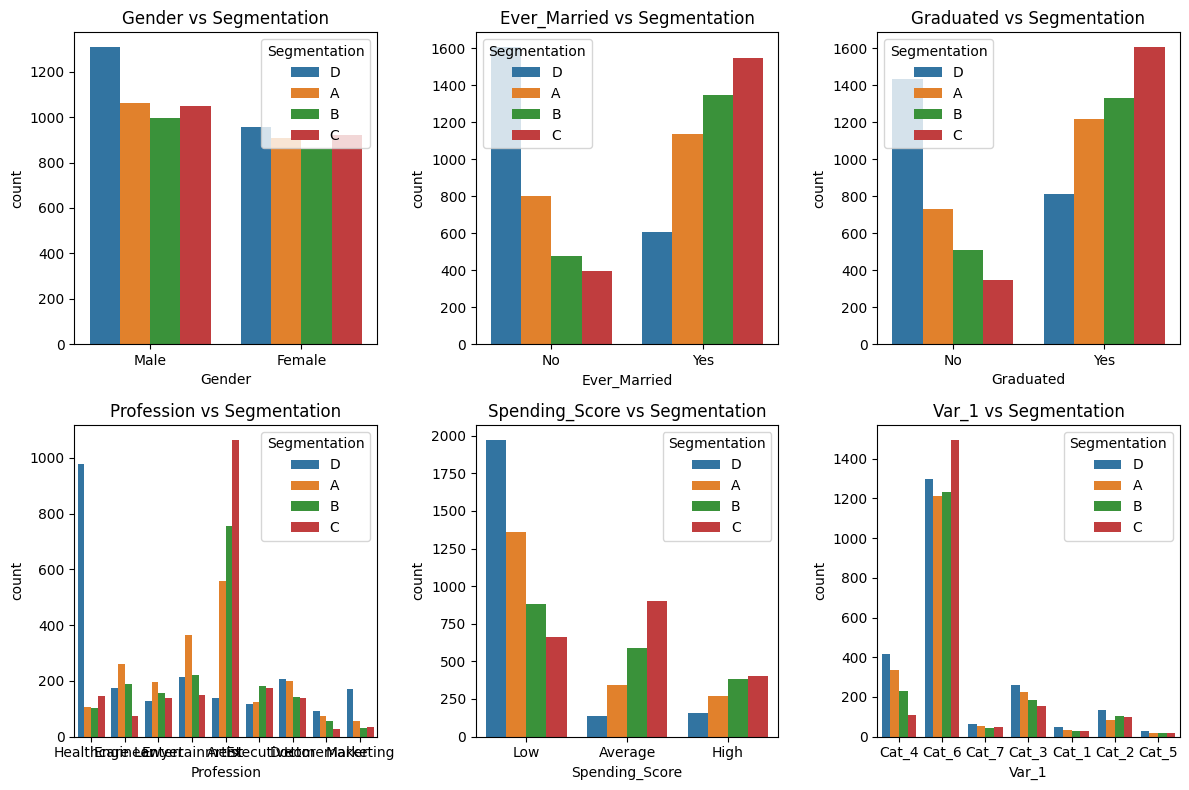

In [8]:
#plot countplots for categorical column
cat_col = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

#plot count plots for categorical columns
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

for i, column in enumerate(cat_col):
    sns.countplot(x=column, hue='Segmentation', data=df, ax=axs[i])
    axs[i].set_title(f"{column} vs Segmentation")

plt.tight_layout()

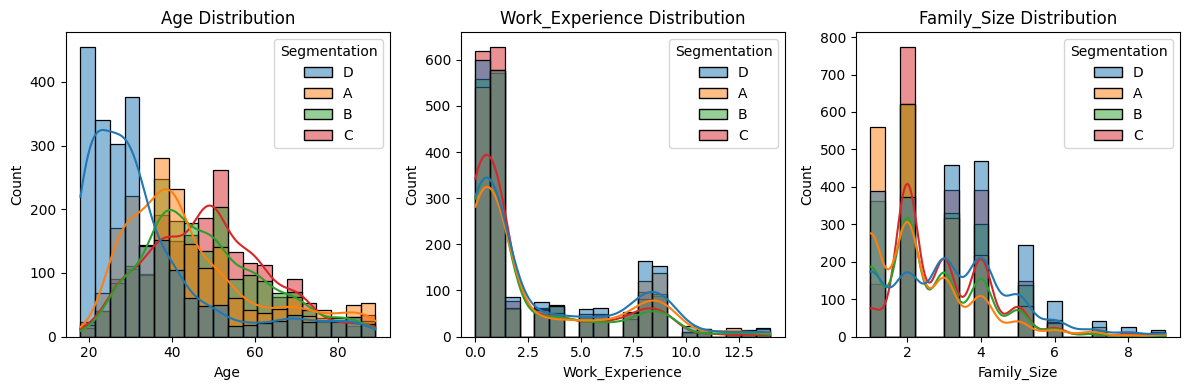

In [9]:
#plot histogram for numerical column
num_col = ['Age', 'Work_Experience', 'Family_Size']

#plot histograms for numerical columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()

for i, column in enumerate(num_col):
    sns.histplot(data=df, x=column, hue='Segmentation', kde=True, ax=axs[i], bins=20)
    axs[i].set_title(f"{column} Distribution")

plt.tight_layout()

plt.show()

### 5. Data cleaning

In [10]:
#fill missing values with the mean in 'Work_Experience' and 'Family_Size' columns
df['Work_Experience'].fillna(df['Work_Experience'].mean(), inplace=True)
df['Family_Size'].fillna(df['Family_Size'].mean(), inplace=True)

#for categorical columns fill missing values with mode
df['Ever_Married'].fillna(df['Ever_Married'].mode()[0], inplace=True)
df['Graduated'].fillna(df['Graduated'].mode()[0], inplace=True)
df['Profession'].fillna(df['Profession'].mode()[0], inplace=True)
df['Var_1'].fillna(df['Var_1'].mode()[0], inplace=True)

In [11]:
#handling data anomaly
df.loc[df['Graduated'] == 'No', 'Profession'] = 'Other'

In [12]:
#for categorical data, the string in the column needed to be transformed into numerical
label_encoder = LabelEncoder()
categorical_col = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
for col in categorical_col:
    df[col] = label_encoder.fit_transform(df[col])

In [13]:
#drop 'ID' column
df.drop('ID', axis=1, inplace=True)

In [14]:
X = df.drop('Segmentation', axis=1)
y = df['Segmentation']

In [15]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,22,0,9,1.000000,2,4.0,3,D
1,0,1,38,1,2,2.641663,0,3.0,3,A
2,0,1,67,1,2,1.000000,2,1.0,5,B
3,1,1,67,1,7,0.000000,1,2.0,5,B
4,0,1,40,1,3,2.641663,1,6.0,5,A


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,8068.0,0.547471,0.497772,0.0,0.0,1.000000,1.0,1.0
Ever_Married,8068.0,0.592836,0.491336,0.0,0.0,1.000000,1.0,1.0
Age,8068.0,43.466906,16.711696,18.0,30.0,40.000000,53.0,89.0
Graduated,8068.0,0.625434,0.484041,0.0,0.0,1.000000,1.0,1.0
Profession,8068.0,4.739836,3.850609,0.0,0.0,5.000000,9.0,9.0
Work_Experience,8068.0,2.641663,3.226972,0.0,0.0,1.000000,4.0,14.0
Spending_Score,8068.0,1.359941,0.848418,0.0,1.0,2.000000,2.0,2.0
Family_Size,8068.0,2.850123,1.499278,1.0,2.0,2.850123,4.0,9.0
Var_1,8068.0,4.147372,1.419453,0.0,3.0,5.000000,5.0,6.0


In [17]:
df.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   int32  
 1   Ever_Married     8068 non-null   int32  
 2   Age              8068 non-null   int64  
 3   Graduated        8068 non-null   int32  
 4   Profession       8068 non-null   int32  
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   int32  
 7   Family_Size      8068 non-null   float64
 8   Var_1            8068 non-null   int32  
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int32(6), int64(1), object(1)
memory usage: 441.3+ KB


### 6. Data normalization

In [19]:
#normalize numerical features
ss = StandardScaler()
X_normalized = ss.fit_transform(X)

### 7. Data splitting

In [20]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [21]:
#encode the target variable using LabelEncoder
encoder_label = LabelEncoder()
y_train_new = encoder_label.fit_transform(y_train)
y_test_new = encoder_label.transform(y_test)

- Gradient boosting classifier

In [ ]:
# Create the Gradient Boosting Classifier
# gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# # Train the model
# gb_classifier.fit(X_train, y_train)

# # Evaluate the model
# test_accuracy = gb_classifier.score(X_test, y_test)
# print("Test Accuracy:", test_accuracy)

# # Calculate F1 Score
# y_pred = gb_classifier.predict(X_test)
# f1 = f1_score(y_test, y_pred, average='weighted')
# print("F1 Score:", f1)

# # Classification Report
# print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

# labels = ['A','B','C','D']
# # Create the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap="Blues")
# plt.rcParams['figure.figsize'] = (5, 5)
# plt.show()

In [22]:
#build the deep learning Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

### 8. Compile the model

In [23]:
#compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

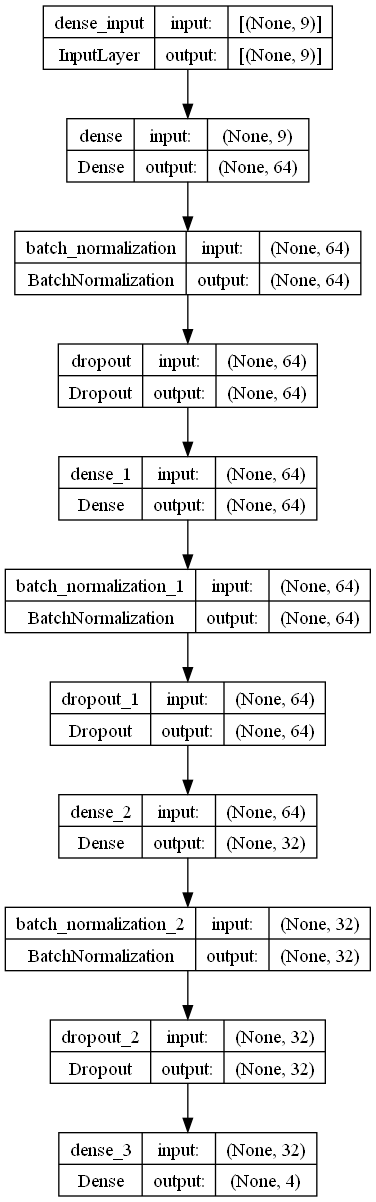

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [25]:
#creating tensorboard object
base_log_path = r"tensorboard_logs\customer_segmentation"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

### 8. Model training

In [26]:
early_stopping = callbacks.EarlyStopping(patience=3)

In [27]:
#train the model
history = model.fit(X_train, y_train_new, batch_size=74, epochs=470, validation_data=(X_test, y_test_new), callbacks=[early_stopping,tb])

Epoch 1/470
77/77 [==============================] - 3s 10ms/step - loss: 1.7410 - accuracy: 0.2764 - val_loss: 1.3854 - val_accuracy: 0.3007
Epoch 2/470
77/77 [==============================] - 1s 8ms/step - loss: 1.5303 - accuracy: 0.3395 - val_loss: 1.3340 - val_accuracy: 0.3614
Epoch 3/470
77/77 [==============================] - 1s 8ms/step - loss: 1.4144 - accuracy: 0.3880 - val_loss: 1.2724 - val_accuracy: 0.4011
Epoch 4/470
77/77 [==============================] - 1s 8ms/step - loss: 1.3644 - accuracy: 0.4045 - val_loss: 1.2310 - val_accuracy: 0.4325
Epoch 5/470
77/77 [==============================] - 1s 9ms/step - loss: 1.3204 - accuracy: 0.4223 - val_loss: 1.2087 - val_accuracy: 0.4436
Epoch 6/470
77/77 [==============================] - 1s 8ms/step - loss: 1.3005 - accuracy: 0.4293 - val_loss: 1.1943 - val_accuracy: 0.4502
Epoch 7/470
77/77 [==============================] - 1s 8ms/step - loss: 1.2868 - accuracy: 0.4280 - val_loss: 1.1841 - val_accuracy: 0.4585
Epoch 8/470


### 9. Model evaluate

In [28]:
#evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_new)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

76/76 [==============================] - 0s 4ms/step - loss: 1.0926 - accuracy: 0.5122
Test Loss: 1.0925893783569336
Test Accuracy: 0.5121850371360779


In [29]:
#calculate F1 Score
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test_new, y_pred_labels, average='weighted')
print("F1 Score:", f1)

76/76 [==============================] - 0s 2ms/step
F1 Score: 0.5021260654206247


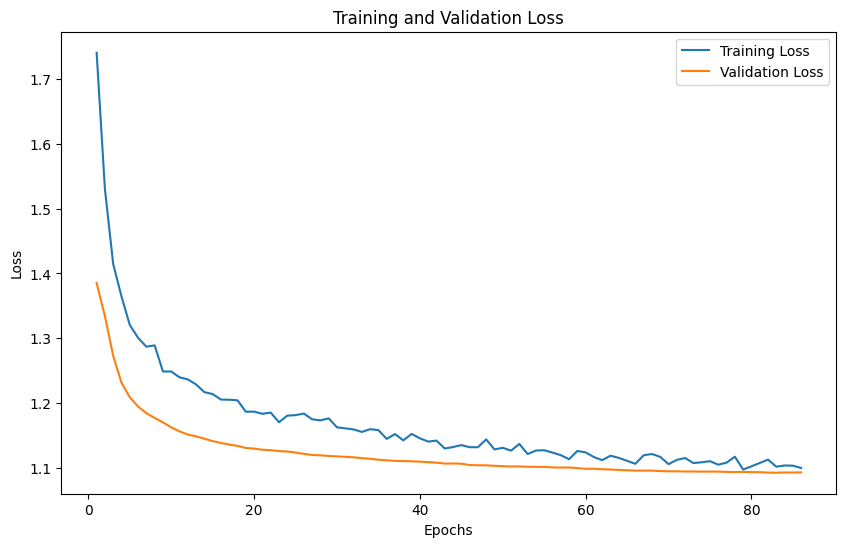

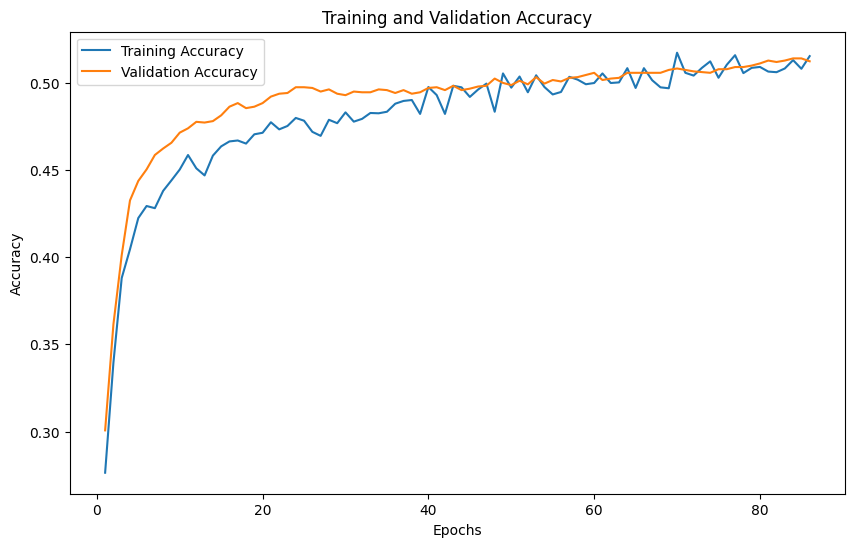

In [30]:
#plotting the loss and accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#create a range of epochs for the x-axis
epochs = range(1, len(training_loss) + 1)

#plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#plot the training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Classification Report: 
              precision    recall  f1-score   support

           0       0.42      0.43      0.42       597
           1       0.41      0.28      0.33       552
           2       0.53      0.56      0.55       580
           3       0.62      0.73      0.67       692

    accuracy                           0.51      2421
   macro avg       0.49      0.50      0.49      2421
weighted avg       0.50      0.51      0.50      2421



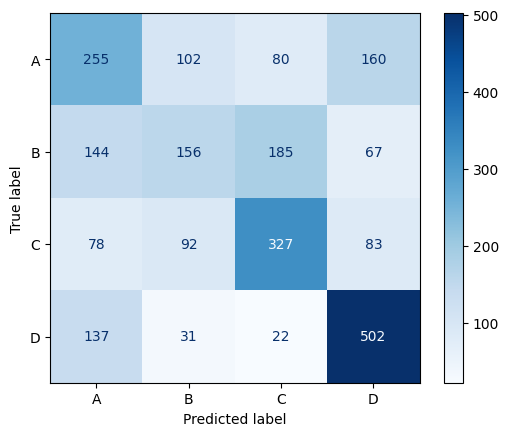

In [31]:
labels = ['A','B','C','D']

#classification Report
print(f"Classification Report: \n{classification_report(y_test_new, y_pred_labels)}")

#create the confusion matrix
cm = confusion_matrix(y_test_new, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.rcParams['figure.figsize'] = (5, 5)
plt.show()

### 10. Save model

In [32]:
#save the model
model.save('model.h5')

Conclusion:

The neural network model achieved an accuracy of 0.5121850371360779 and an F1 score of 0.5021260654206247. The gradient boosting model, on the other hand, achieved an accuracy of 0.52292441144002478 and an F1 score of 0.5162779030215546. Both does not achieve either 60% or 65% accuracy. However, this suggests that the gradient boosting model is better suited for this dataset than the neural network model.

There are a few possible reasons why the neural network model didn't work as well as the gradient boosting model. First, the neural network model may be too complex for this dataset. The dataset is relatively small, and the neural network model may be overfitting the data. Second, the neural network model may not be able to capture the nonlinear relationships in the data. The gradient boosting model, on the other hand, is a more linear model, and it may be better able to capture the nonlinear relationships in the data.